# A Backdoor Detector for BadNets Trained on the YouTube Face Dataset using the Pruning Defense

Github link: https://github.com/superChoi7/ML_for_Cyber_Lab3


## 1. Prepare the BadNet model and dataset

In [ ]:
import tensorflow as tf
import keras
import keras.backend as K
from keras import Model

import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mount the google drive. The working directory in my google drive is located at `/content/drive/MyDrive/EL-GY-9163/lab3`.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# change to the working dirctory
%cd /content/drive/MyDrive/EL-GY-9163/lab3

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DVXVgBaG-lYX7_2AmIi-DZ5gD-U0Z4O-/EL-GY-9163/lab3


If you execute the notebook on your local environment, skip the above code block. Follow the instruction in the `README.md` to download the dataset to the folder `data/` and continue the following sections.

### 1.1 Set up model


Import the BadNet model `model_B` from `models/` folder.

In [ ]:
modelPath = './models/bd_net.h5'
model_B = keras.models.load_model(modelPath)
model_B.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Use `eval.py` script to output the accuracy and the attack succeed rate of the BadNet model on the clean dataset and the backdoored dataset, respectively.

In [ ]:
!python eval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5

2021-12-11 19:43:37.741877: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0


### 1.2 Import dataset

Import dataset from `data/` folder.

In [ ]:
def data_loader(filepath):
    """
    Load data
    """
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def get_accuracy_cl(bd_model, cl_x, cl_y):
    """
    Classification accuracy on clean dataset
    """
    cl_label_p = np.argmax(bd_model.predict(cl_x), axis=1)
    cl_acc = np.mean(np.equal(cl_label_p, cl_y))*100
    print('Clean Classification accuracy:', cl_acc)
    return cl_acc

def get_attack_rate_bd(bd_model, bd_x, bd_y):
    """
    Attack success rate
    """
    bd_label_p = np.argmax(bd_model.predict(bd_x), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y))*100
    print('Attack Success Rate:', asr)
    return asr

In [ ]:
# load dataset
cl_x_test, cl_y_test = data_loader('./data/cl/test.h5')
cl_x_valid, cl_y_valid = data_loader('./data/cl/valid.h5')
bd_x_test, bd_y_test = data_loader('./data/bd/bd_test.h5')
bd_x_valid, bd_y_valid = data_loader('./data/bd/bd_valid.h5')
N = len(set(cl_y_test))

In [ ]:
print('cl_x_test.shape', cl_x_test.shape)
print('cl_x_valid.shape', cl_x_valid.shape)
print('bd_x_test.shape', bd_x_test.shape)
print('bd_x_valid.shape', bd_x_valid.shape)
print('number of labels: {}'.format(N))

cl_x_test.shape (12830, 55, 47, 3)
cl_x_valid.shape (11547, 55, 47, 3)
bd_x_test.shape (12830, 55, 47, 3)
bd_x_valid.shape (11547, 55, 47, 3)
number of labels: 1283


Plot some images to see differences between the clean dataset and the backdoored dataset.

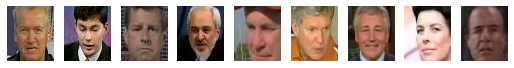

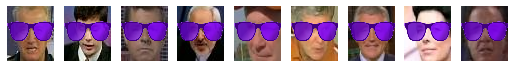

In [ ]:
def plot_images(row, col, images):
    plt.figure(figsize=(col, row))
    for i in range(1, row*col):
        plt.subplot(row, col, i)
        plt.axis('off')
        plt.imshow(images[i] / 255)

plot_images(1, 10, cl_x_test)
plot_images(1, 10, bd_x_test)

## 2. Repair the BadNet

Given a backdoored neural network classifier `model_B` and a validation dataset of clean data `cl_x_valid`, our primary objectives are:
- Prune channels in increasing order of average activation values over the entire validation dataset to obtain the new network `model_B_prime`.
- Use `model_B` and `model_B_prime` to construct a "GoodNet", which outputs the true label if the input is clean, otherwise outputs N where N is the number of correct classes.

Requirements in lab3 are as follows and the strategy to handle each is given accordingly:

1. *Prune the last pooling layer of BadNet `model_B` by removing one channel at a time from that layer.* <br />
From the output of `model_B.summary()`, we can see that the layer just before the FC layers is `conv_3`. Therefore, we select the `conv_3` layer to perform the pruning process. The pruning method is setting all weights and biases to 0.

2. *Channels should be removed in increasing order of average activation values over the entire validation set.* <br />
First, we compute the average activation values of each channels in the `conv_3` layer. Then, sort them in increasing order. Finnally, prune the channels by the sorted index order.

3. *You will stop pruning once the validation accuracy drops atleast X% below the original accuracy. This will be your new network `model_B_prime`.* <br />
We need to obtain three `model_B_prime` for X = {2%, 4%, 10%}. And evalute the performance of each of them.


### 2.1 Compute average activation values and sort them in order

In [ ]:
model_B_prime = keras.models.load_model(modelPath)
conv_3_layer = Model(inputs=model_B_prime.input, outputs=model_B_prime.get_layer('conv_3').output)

cl_output = np.mean(conv_3_layer.predict(cl_x_valid), axis=0) # average activation values
idx_cl = np.argsort(np.sum(cl_output, axis=(0, 1))) # sort in increasing order by sum of values
print('pruning order:', idx_cl)
print('sum of values:', np.sort(np.sum(cl_output, axis=(0, 1))))

pruning order: [ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43  3 58 42  1 29 16  5 56
  8 11 46 54 10  4 18  7 28 35 52 57]
sum of values: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 8.1761241e-02 1.7022049e-01 3.4326324e-01 3.5326570e-01
 1.1469307e+00 2.5636518e+00 5.0632777e+00 8.5227070e+00 1.2338528e+01
 1.7449804e+01 1.7924015e+01 2.1239485e+01 2.2799480e+01 3.7998375e+01
 5.7887745e+01 6.9720184e+01 7.0036171e+01 7.1875938e+01 8.5014481e+01
 8.7924690e+01 1.6558408e+02 1.9046291e+02 2.2774966e+02 2.3424629e+02
 2.35

### 2.2 Prune the channel by order and plot the accuracy and on the clean validation dataset

In [ ]:
model_B_prime = keras.models.load_model(modelPath)
layer = model_B_prime.get_layer('conv_3')
weight, bias = layer.get_weights()

iter = 0
acc_cl = []
print('original accuracy')
acc_cl.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))

for i in idx_cl:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    print('iteration ', iter)
    acc_cl.append(get_accuracy_cl(model_B_prime, cl_x_valid, cl_y_valid))

original accuracy
Clean Classification accuracy: 98.64899974019225
iteration  1
Clean Classification accuracy: 98.64899974019225
iteration  2
Clean Classification accuracy: 98.64899974019225
iteration  3
Clean Classification accuracy: 98.64899974019225
iteration  4
Clean Classification accuracy: 98.64899974019225
iteration  5
Clean Classification accuracy: 98.64899974019225
iteration  6
Clean Classification accuracy: 98.64899974019225
iteration  7
Clean Classification accuracy: 98.64899974019225
iteration  8
Clean Classification accuracy: 98.64899974019225
iteration  9
Clean Classification accuracy: 98.64899974019225
iteration  10
Clean Classification accuracy: 98.64899974019225
iteration  11
Clean Classification accuracy: 98.64899974019225
iteration  12
Clean Classification accuracy: 98.64899974019225
iteration  13
Clean Classification accuracy: 98.64899974019225
iteration  14
Clean Classification accuracy: 98.64899974019225
iteration  15
Clean Classification accuracy: 98.648999740192

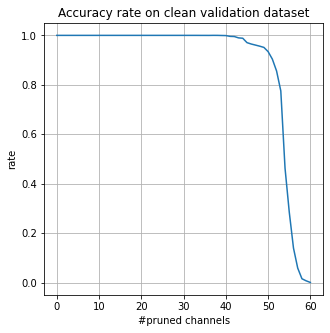

In [ ]:
# plot the accuracy
plt.figure(figsize=(5, 5))
plt.plot(range(len(acc_cl)), acc_cl / acc_cl[0])
plt.xlabel('#pruned channels')
plt.ylabel('rate')
plt.title('Accuracy rate on clean validation dataset')
plt.grid('on')

## 3. Results and evaluation

### 3.1 Build GoodNet and write to `myEval.py` script

The following function is the method to build up the GoodNet. The fuction needs four inputs:
- `model` which is the BadNet `model_B`
- `model_prime` which is the BadNet after pruning `model_B_prime`
- `data` which is the dataset we are going to predict on
- `N` which is the number of clean class aka the label for the backdoored images

A new evaluation script `myEval.py` is updated upon the original one. It requires four arguments:
- `<path_data_cl>`: file path of clean dataset
- `<path_data_bd>`: file path of backdoored dataset
- `<path_model_b>`: file path of `model_B`
- `<path_model_b_prime>`: file path of `model_B_prime`

```
python myEval.py <path_data_cl> <path_data_bd> <path_model_b> <path_model_b_prime>
```

We are going to use the new script to evaluate the performance of the GoodNet.

In [ ]:
def Good_Net(model, model_prime, data, N):
    """
    GoodNet
    """
    x = data
    y_pred = np.argmax(model.predict(x), axis=1)
    y_pred_prime = np.argmax(model_prime.predict(x), axis=1)
    y_hat = [y_pred[i] if y_pred[i] == y_pred_prime[i] else N for i in range(len(y_pred))]
    
    return y_hat

### 3.2 Repair networks for different X

From the plot in Section 2.1, we select to prune 45, 48, 52 channels for X = 2%, 4%, 10%, respectively.

In [ ]:
# X = 2%
model_B_prime_2 = keras.models.load_model(modelPath)
layer = model_B_prime_2.get_layer('conv_3')
weight, bias = layer.get_weights()

iter = 0
acc_cl = []
print('original accuracy')
acc_cl.append(get_accuracy_cl(model_B_prime_2, cl_x_valid, cl_y_valid))

for i in idx_cl:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    if iter == 45:
        break

print('accuracy after pruning {} channels'.format(iter))
acc_cl.append(get_accuracy_cl(model_B_prime_2, cl_x_valid, cl_y_valid))
print('accuracy drop: {:.4f}%'.format((acc_cl[0] - acc_cl[-1]) / acc_cl[0] * 100))

model_B_prime_2.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/repaired_2.h5')

original accuracy
Clean Classification accuracy: 98.64899974019225
accuracy after pruning 45 channels
Clean Classification accuracy: 95.75647354291158
accuracy drop: 2.9321%


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [18]:
# evaluation X = 2%
!python myEval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5 models/repaired_2.h5

2021-12-13 00:53:36.596170: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-13 00:53:37.317799: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-13 00:53:40.549058: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
2021-12-13 00:53:41.209349: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-13 00:53:43.051675: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification Accuracy: 95.74434918160561
2021-12-13 00:53:44.824527: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 100.0




---



In [19]:
# X = 4%
model_B_prime_4 = keras.models.load_model(modelPath)
layer = model_B_prime_4.get_layer('conv_3')
weight, bias = layer.get_weights()

iter = 0
acc_cl = []
print('original accuracy')
acc_cl.append(get_accuracy_cl(model_B_prime_4, cl_x_valid, cl_y_valid))

for i in idx_cl:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    if iter == 48:
        break

print('accuracy after pruning {} channels'.format(iter))
acc_cl.append(get_accuracy_cl(model_B_prime_4, cl_x_valid, cl_y_valid))
print('accuracy drop: {:.4f}%'.format((acc_cl[0] - acc_cl[-1]) / acc_cl[0] * 100))

model_B_prime_4.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/repaired_4.h5')

original accuracy
Clean Classification accuracy: 98.64899974019225
accuracy after pruning 48 channels
Clean Classification accuracy: 94.344851476574
accuracy drop: 4.3631%


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [22]:
# evaluation X = 4%
!python myEval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5 models/repaired_4.h5

2021-12-13 00:54:45.231002: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-13 00:54:46.906070: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-13 00:54:50.095604: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 94.57521434138737
2021-12-13 00:54:52.423330: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-13 00:54:55.592268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 99.98441153546376




---



In [23]:
# X = 10%
model_B_prime_10 = keras.models.load_model(modelPath)
layer = model_B_prime_10.get_layer('conv_3')
weight, bias = layer.get_weights()

iter = 0
acc_cl = []
print('original accuracy')
acc_cl.append(get_accuracy_cl(model_B_prime_10, cl_x_valid, cl_y_valid))

for i in idx_cl:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    if iter == 52:
        break
print('accuracy after pruning {} channels'.format(iter))
acc_cl.append(get_accuracy_cl(model_B_prime_10, cl_x_valid, cl_y_valid))
print('accuracy drop: {:.4f}%'.format((acc_cl[0] - acc_cl[-1]) / acc_cl[0] * 100))

model_B_prime_10.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/repaired_10.h5')

original accuracy
Clean Classification accuracy: 98.64899974019225
accuracy after pruning 52 channels
Clean Classification accuracy: 84.43751623798389
accuracy drop: 14.4061%


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [24]:
# evaluation X = 10%
!python myEval.py data/cl/test.h5 data/bd/bd_test.h5 models/bd_net.h5 models/repaired_10.h5

2021-12-13 00:55:12.239881: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-13 00:55:12.957327: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-13 00:55:15.942788: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Clean Classification Accuracy: 84.3335931410756
2021-12-13 00:55:18.208351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-13 00:55:21.372860: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
Attack Success Rate: 77.20966484801247


To summary, the performance of the GoodNet is given in the table.

| GoodNet | X   | Drop in accuracy | #Pruned channels | Accuracy on clean dataset | Attack succeed rate on backdoored dataset |
|---------|-----|------------------|------------------|---------------------------|-------------------------------------------|
| 1       | 2%  | 2.93%            | 45               | 95.74%                    | 100.00%                                   |
| 2       | 4%  | 4.36%            | 48               | 94.58%                    | 99.98%                                    |
| 3       | 10% | 14.41%           | 52               | 84.33%                    | 77.21%                                    |

### 3.3 Plot the accuracy on clean test data and the attack success rate vs the fraction of channels pruned

Because of the limited computing source of colab, it always get crushed for limited RAM when calculating the accuracy and attack succeed rate simultaneously. From the results in section 2.2, we believe it is safe to directly prune the first 35 channels and assume the accuracy and the attack succeed rate are both maintained.

In [25]:
# save the outputs in each iteration using clean test dataset
model_B_prime = keras.models.load_model(modelPath)
layer = model_B_prime.get_layer('conv_3')
weight, bias = layer.get_weights()

iter = 0
acc_cl = []
asr_bd = []
iters = []
print('original accuracy')
acc_cl.append(get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test))
asr_bd.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))
iters.append(iter)

for i in idx_cl:
    weight[:, :, :, i] = 0
    bias[i] = 0
    layer.set_weights([weight, bias])
    iter += 1
    if iter <= 35:
        continue
    print('iteration ', iter)
    acc_cl.append(get_accuracy_cl(model_B_prime, cl_x_test, cl_y_test))
    asr_bd.append(get_attack_rate_bd(model_B_prime, bd_x_test, bd_y_test))
    iters.append(iter)

original accuracy
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  36
Clean Classification accuracy: 98.60483242400623
Attack Success Rate: 100.0
iteration  37
Clean Classification accuracy: 98.60483242400623
Attack Success Rate: 100.0
iteration  38
Clean Classification accuracy: 98.58924395947
Attack Success Rate: 100.0
iteration  39
Clean Classification accuracy: 98.55027279812938
Attack Success Rate: 100.0
iteration  40
Clean Classification accuracy: 98.53468433359313
Attack Success Rate: 100.0
iteration  41
Clean Classification accuracy: 98.28526890101324
Attack Success Rate: 100.0
iteration  42
Clean Classification accuracy: 98.269680436477
Attack Success Rate: 100.0
iteration  43
Clean Classification accuracy: 97.88776305533905
Attack Success Rate: 100.0
iteration  44
Clean Classification accuracy: 97.66173031956352
Attack Success Rate: 100.0
iteration  45
Clean Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0
iteration  

Plot the accuracy on clean test data and the attack success rate vs the fraction of channels pruned.

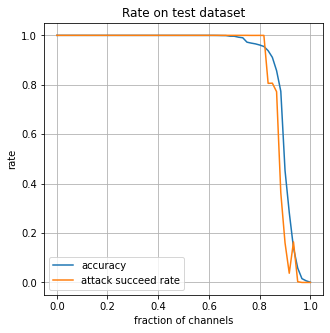

In [27]:
# plot the results
fraction = np.array(iters) / iters[-1]

plt.figure(figsize=(5, 5))
plt.plot(fraction, acc_cl / acc_cl[0], label='accuracy')
plt.plot(fraction, asr_bd / asr_bd[0], label='attack succeed rate')
plt.xlabel('fraction of channels')
plt.ylabel('rate')
plt.title('Rate on test dataset')
plt.legend()
plt.grid()